# Exercise 4

## Import packages

In [103]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

## Task 1
(3 points)

Implement the training loop for one training epoch.
An epoch trains on the whole training dataset once.

In [104]:
def train(model, use_cuda, train_loader, optimizer, epoch, log_interval):
    """
    Train one epoch
    
    model -- the neural network
    use_cuda -- true if GPU should be used
    train_loader -- data loader
    optimizer -- network optimizer
    epoch -- number of current epoch
    log_interval -- number of training steps between logs
    """
    # TODO: set the model to train mode
    model.train()
    loss_func = nn.NLLLoss()
    
    
    # TODO: enumerate over the dataloader to get mini batches
    #       of images and ground truth labels
    # HINT: the builtin python function enumerate() also gives you indices
    for i, (inpt, gt) in enumerate(train_loader):
        
        # TODO: set the optimizers gradients to zero
        optimizer.zero_grad()
        
        
        # TODO: run the network
        pred = model(inpt)
        
        # TODO: compute negative log likelihood loss
        # NLLLoss is doing this but also expands the gt to binary 10 channel
        # loss = -(gt * torch.log(pred) + (1 - gt) * torch.log(1 - pred))
        # loss = loss.sum()
        loss = loss_func(pred, gt)
        
        # TODO: do backpropagation
        loss.backward()
        
        # TODO: optimize
        optimizer.step()
        
        # TODO: print current loss for every nth ("log_interval"th) iteration
        if i%log_interval == 0:
              print(loss.item())
        

We already implemented the validation function for you (this is essentially validate() from the last exercise)

In [105]:
def validate(model, use_cuda, test_loader):
    """
    Compute test metrics
    
    model -- the neural network
    use_cuda -- true if GPU should be used
    test_loader -- data loader
    """
    # create a 10x10 grid of subplots
    _, axis = plt.subplots(10, 10)
    
    # set model to evaluation mode
    model.eval()
    test_loss = 0
    correct = 0
    plotted = 0
    
    # disable gradients globally
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            # for each batch
            if use_cuda:
                # transfer to GPU
                data = data.cuda()
                target = target.cuda()
            
            # run network and compute metrics
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            
            img_correct = pred.eq(target.view_as(pred))
            correct += pred.eq(target.view_as(pred)).sum().item()
            
            # plot the first 100 images
            img_idx = 0
            data = data.cpu().numpy()
            
            while plotted < 100 and img_idx < data.shape[0]:
                # compute position of ith image in the grid
                y = plotted % 10
                x = plotted // 10
                
                # convert image tensor to numpy array and normalize to [0, 1]
                img = data[img_idx, 0]
                img = (img - np.min(img)) / (np.max(img) - np.min(img))
                
                # make wrongly predicted images red
                img = np.stack([img] * 3, 2)
                if img_correct[img_idx] == 0:
                    img[:, :, 1:] = 0.0
                
                # disable axis and show image
                axis[y][x].axis('off')
                axis[y][x].imshow(img)
                
                # show the predicted class next to each image
                axis[y][x].text(30, 25, pred[img_idx].item())
                
                plotted += 1
                img_idx += 1
            
    test_loss /= len(test_loader.dataset)

    # show results
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    plt.show()

## Task 2
(4 points)

Implement a five-layer fully connected neural network.
The dimensions (without batch size) should change like this: 784->200->100->60->30->10
Use log softmax to compute the class predictions.

Run the code at the end of the notebook to train and validate your implementation.

### Task 2.1
* sigmoid non-linear activation function
* note that the last layer does not need an activation function!

### Task 2.2
* add a new class "FCNet2"
* replace sigmoid with ReLU

### Task 2.3
* add a new class "FCNet2"
* add batch normalization to the first and third layers (note the difference between 1D/2D/3D versions)


**NOTE:** The perfomance should improve slightly with each step. However, due to the random weight initialization applied by PyTorch, your results may vary a bit between trainings.

In [106]:
class FCNet1(nn.Module):
    """
    Fully Connected Neural Network
    
    Five fully connected layers with sigmoid non-linearity
    
    Dimensions
    784->200->100->60->30->10
    """
    def __init__(self):
        super(FCNet1, self).__init__()
        
        # TODO: initialize network layers
        # HINT: take a look at "torch.nn" (imported as "nn")
        
        self.nl = nn.Sequential(nn.Linear(784, 200), nn.Sigmoid(), 
                                nn.Linear(200, 100), nn.Sigmoid(), 
                                nn.Linear(100, 60), nn.Sigmoid(), 
                                nn.Linear(60, 30), nn.Sigmoid(), 
                                nn.Linear(30, 10))
       

    def forward(self, x):
        # TODO: reshape batch of images to batch of 1D vectors
        inpt = x.view(x.shape[0], -1)
        
        
        # TODO: run network layers
        out = self.nl(inpt)
        
        # TODO: compute log softmax over the output
        # HINT: take a look at "torch.nn.functional" (imported as "F")
        output = torch.nn.functional.softmax(out, dim=1)
        
        return output

In [107]:
class FCNet2(nn.Module):
    def __init__(self):
        super(FCNet2, self).__init__()
        
        self.nl = nn.Sequential(nn.Linear(784, 200), nn.ReLU(), 
                        nn.Linear(200, 100), nn.ReLU(), 
                        nn.Linear(100, 60), nn.ReLU(), 
                        nn.Linear(60, 30), nn.ReLU(), 
                        nn.Linear(30, 10))

    def forward(self, x):
        inpt = x.view(x.shape[0], -1)
        out = self.nl(inpt)
        return torch.nn.functional.softmax(out, dim=1)

In [108]:
class FCNet3(nn.Module):
    def __init__(self):
        super(FCNet3, self).__init__()
        
        self.nl = nn.Sequential(nn.Linear(784, 200), nn.ReLU(), nn.BatchNorm1d(200),
                                nn.Linear(200, 100), nn.ReLU(), 
                                nn.Linear(100, 60), nn.ReLU(), nn.BatchNorm1d(60),
                                nn.Linear(60, 30), nn.ReLU(), 
                                nn.Linear(30, 10))
       

    def forward(self, x):
        inpt = x.view(x.shape[0], -1)
        out = self.nl(inpt)
        return torch.nn.functional.softmax(out, dim=1)


## Task 3
(3 points)

Implement a convolutional neural network, consisting of two convolutional and two fully connected layers.
This time, the dimensions (without batch size) should change like this: 1x28x28->32x26x26->64x12x12->128->10

### Task 3.1
* two convolutional layers (kernel size 3)
* two fully-connected layers
* ReLU activation function

### Task 3.2
* add batch normalization to first convolutional and first fully connected layer

### Task 3.3
* use max pooling instead of stride to reduce the dimensions to 64x12x12

In [109]:
class ConvNet1(nn.Module):
    """
    Convolutional Neural Network
    
    Two convolutional layers and two fully connected layers
    
    Dimensions:
    1x28x28->32x26x26->64x12x12->128->10
    """
    def __init__(self):
        super(ConvNet1, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3, stride=2)
        self.ll1 = nn.Linear(64 * 12 * 12, 128)
        self.ll2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.conv1(x)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.relu(out)
        
        out = out.view(out.shape[0], -1)
        
        out = self.ll1(out)
        out = self.relu(out)
        out = self.ll2(out)       
        
        return torch.nn.functional.softmax(out, dim=1)

In [110]:
class ConvNet2(nn.Module):
    def __init__(self):
        super(ConvNet2, self).__init__()

        self.conv1 = nn.Conv2d(1, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3, stride=2)
        self.ll1 = nn.Linear(64 * 12 * 12, 128)
        self.ll2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
        self.bn1 = nn.BatchNorm1d(128)
        self.bn2 = nn.BatchNorm2d(32)

    def forward(self, x):

        out = self.conv1(x)
        out = self.relu(out)
        out = self.bn2(out)
        out = self.conv2(out)
        out = self.relu(out)
        
        out = out.view(out.shape[0], -1)
        
        out = self.ll1(out)
        out = self.relu(out)
        out = self.bn1(out)
        out = self.ll2(out)       
        
        return torch.nn.functional.softmax(out, dim=1)

In [111]:
class ConvNet3(nn.Module):
    def __init__(self):
        super(ConvNet3, self).__init__()

        self.conv1 = nn.Conv2d(1, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.mp = nn.MaxPool2d(2)
        self.ll1 = nn.Linear(64 * 12 * 12, 128)
        self.ll2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
        self.bn1 = nn.BatchNorm1d(128)
        self.bn2 = nn.BatchNorm2d(32)

    def forward(self, x):

        out = self.conv1(x)
        out = self.relu(out)
        out = self.bn2(out)
        out = self.conv2(out)
        out = self.relu(out)
        out = self.mp(out)
        
        out = out.view(out.shape[0], -1)
        
        out = self.ll1(out)
        out = self.relu(out)
        out = self.bn1(out)
        out = self.ll2(out)       
        
        return torch.nn.functional.softmax(out, dim=1)

-0.09828709065914154
-0.10440729558467865
-0.1556818187236786
-0.08070062100887299
-0.12385748326778412
-0.10911731421947479
-0.09369238466024399
-0.14018285274505615
-0.1245940774679184
-0.12484448403120041

Test set: Average loss: -0.1134, Accuracy: 1135/10000 (11.35%)



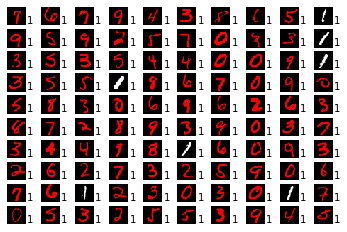

-0.07826504856348038
-0.12480670213699341
-0.04715844616293907
-0.12476997077465057
-0.21811558306217194
-0.10938961803913116
-0.20268088579177856
-0.10935795307159424
-0.10931213200092316
-0.06268098205327988

Test set: Average loss: -0.1135, Accuracy: 1135/10000 (11.35%)



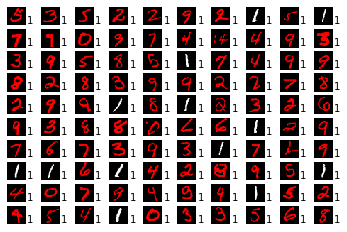

-0.06265806406736374
-0.09374798834323883
-0.15604262053966522
-0.17162007093429565
-0.10932841151952744
-0.12487820535898209
-0.03147371485829353
-0.10933235287666321
-0.17166242003440857
-0.06265228986740112

Test set: Average loss: -0.1135, Accuracy: 1135/10000 (11.35%)



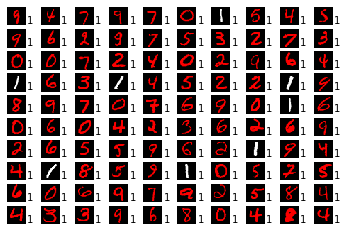

-0.1560925841331482
-0.14050249755382538
-0.06262654066085815
-0.14051035046577454
-0.06259976327419281
-0.12495965510606766
-0.07815607637166977
-0.06258128583431244
-0.09375546872615814
-0.12495382130146027

Test set: Average loss: -0.1135, Accuracy: 1135/10000 (11.35%)



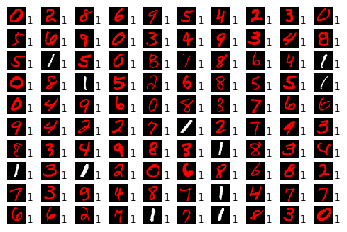

-0.1405036896467209
-0.015825951471924782
-0.124968983232975
-0.07817219942808151
-0.06258038431406021
-0.09374140948057175
-0.12495102733373642
-0.12493979930877686
-0.04697475582361221
-0.10936321318149567

Test set: Average loss: -0.1135, Accuracy: 1135/10000 (11.35%)



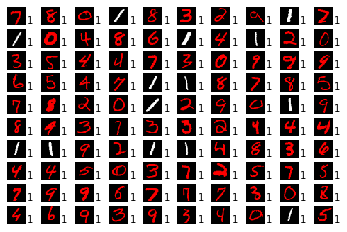

-0.15615986287593842
-0.10935806483030319
-0.10935625433921814
-0.07814443856477737
-0.09375423938035965
-0.03137585520744324
-0.09377197921276093
-0.12493223696947098
-0.07816608995199203
-0.09376496821641922

Test set: Average loss: -0.1135, Accuracy: 1135/10000 (11.35%)



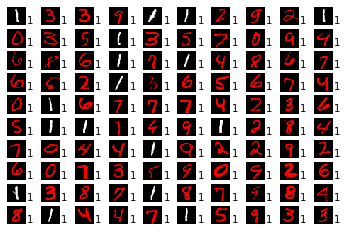

-0.10936496406793594
-0.09374760091304779
-0.06257029622793198
-0.15615642070770264
-0.0937512144446373
-0.07819010317325592
-0.09376056492328644
-0.07816570997238159
-0.09377449005842209
-0.07816444337368011

Test set: Average loss: -0.1135, Accuracy: 1135/10000 (11.35%)



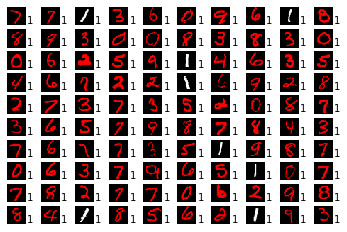

-0.10937639325857162
-0.14055170118808746
-0.0469738207757473
-0.0937640368938446
-0.04696032404899597
-0.07816825062036514
-0.1405479907989502
-0.07818172127008438
-0.07815632224082947
-0.1717250645160675

Test set: Average loss: -0.1135, Accuracy: 1135/10000 (11.35%)



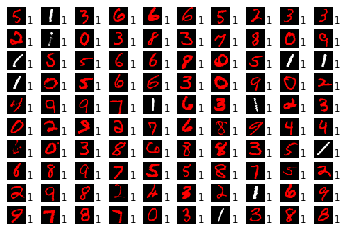

-0.09376954287290573
-0.07817643880844116
-0.07815196365118027
-0.14055417478084564
-0.10933516919612885
-0.15612953901290894
-0.10936256498098373
-0.09377475082874298
-0.17172542214393616
-0.10935742408037186

Test set: Average loss: -0.1135, Accuracy: 1135/10000 (11.35%)



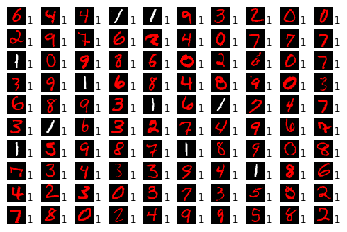

-0.10934989154338837
-0.10933191329240799
-0.15615174174308777
-0.04698038101196289
-0.09377016127109528
-0.109336256980896
-0.1717410832643509
-0.06255043298006058
-0.07817001640796661
-0.09375204145908356

Test set: Average loss: -0.1135, Accuracy: 1135/10000 (11.35%)



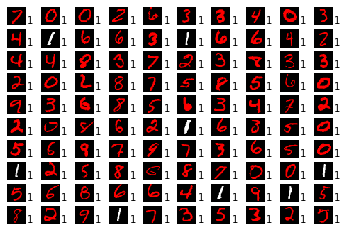

-0.10150603204965591
-0.4652443826198578
-0.6458425521850586
-0.767666220664978
-0.8122535943984985
-0.8641757965087891
-0.7481333613395691
-0.7314866185188293
-0.8693481683731079
-0.8411664962768555

Test set: Average loss: -0.9072, Accuracy: 9094/10000 (90.94%)



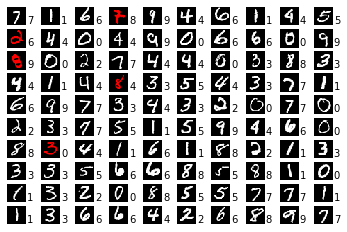

-0.8425647020339966
-0.8987938761711121
-0.8965135812759399
-0.9338436722755432
-0.9404146671295166
-0.9218091368675232
-0.9060182571411133
-0.9487344622612
-0.9781239628791809
-0.9526995420455933

Test set: Average loss: -0.9477, Accuracy: 9486/10000 (94.86%)



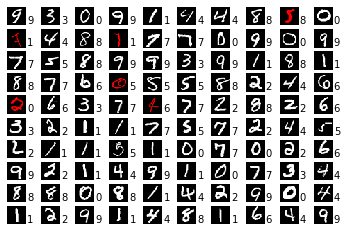

-0.9227689504623413
-0.9615200161933899
-0.9265492558479309
-0.9706695675849915
-0.9297937154769897
-0.9416332244873047
-0.9534590840339661
-0.9664090275764465
-0.9279474020004272
-0.9824221134185791

Test set: Average loss: -0.9588, Accuracy: 9601/10000 (96.01%)



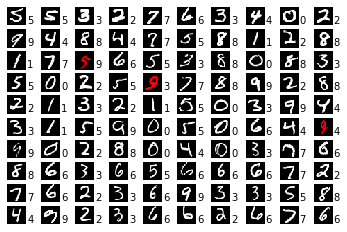

-0.9617552161216736
-0.9764289855957031
-0.9650878310203552
-0.9843550324440002
-0.9396857619285583
-0.9773389101028442
-0.9684866666793823
-0.942237913608551
-0.9925973415374756
-0.9952762126922607

Test set: Average loss: -0.9614, Accuracy: 9621/10000 (96.21%)



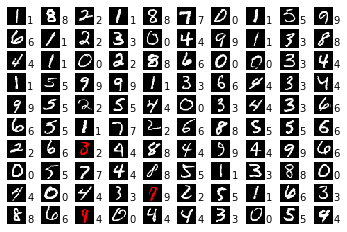

-0.9843717217445374
-0.9654107689857483
-0.984387993812561
-0.9590245485305786
-0.9579789638519287
-0.9866721034049988
-0.9942498803138733
-0.9483731389045715
-0.9999966621398926
-0.9616181254386902

Test set: Average loss: -0.9679, Accuracy: 9685/10000 (96.85%)



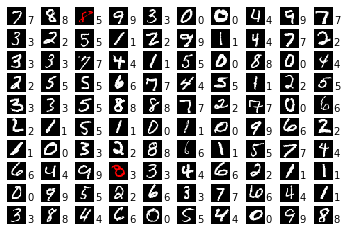

-0.9384526014328003
-0.9734848141670227
-0.9804344773292542
-0.9672755599021912
-0.9775610566139221
-0.9665170311927795
-0.9843354225158691
-0.9833375215530396
-0.9850987792015076
-0.999839186668396

Test set: Average loss: -0.9699, Accuracy: 9713/10000 (97.13%)



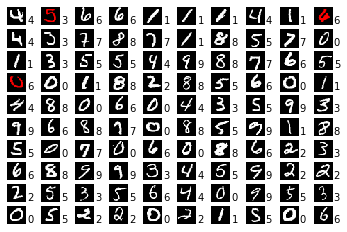

-0.9545594453811646
-0.9842790365219116
-0.9374611377716064
-0.9685696363449097
-0.9843147993087769
-0.9806732535362244
-0.994043231010437
-0.9702596664428711
-0.9997960925102234
-0.9685404300689697

Test set: Average loss: -0.9712, Accuracy: 9724/10000 (97.24%)



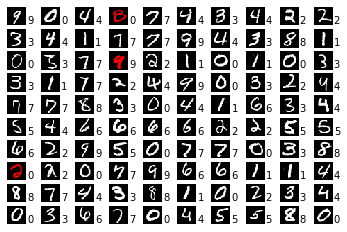

-0.9677183032035828
-0.968705952167511
-0.9999847412109375
-0.999971866607666
-0.9358234405517578
-0.9840575456619263
-0.9843204021453857
-0.9843317270278931
-0.9837473630905151
-0.9730159640312195

Test set: Average loss: -0.9715, Accuracy: 9723/10000 (97.23%)



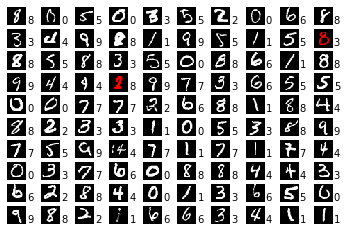

-0.968665599822998
-0.995793342590332
-0.9526327848434448
-0.9843300580978394
-0.9758521914482117
-0.9996256828308105
-0.9760241508483887
-0.9687677621841431
-0.9998101592063904
-0.9999926686286926

Test set: Average loss: -0.9717, Accuracy: 9722/10000 (97.22%)



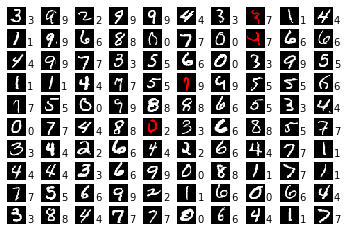

-0.9839885234832764
-0.9680931568145752
-0.997800350189209
-0.9536433219909668
-0.9843632578849792
-0.9700380563735962
-0.9684772491455078
-0.9838601350784302
-0.955996036529541
-0.9843304753303528

Test set: Average loss: -0.9717, Accuracy: 9723/10000 (97.23%)



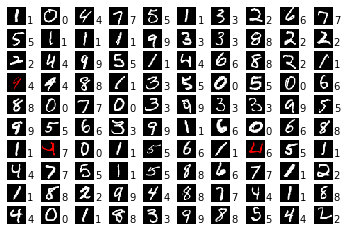

-0.1004108339548111
-0.9056082367897034
-0.9680001139640808
-0.9046056270599365
-0.8896256685256958
-0.9517373442649841
-0.9629096984863281
-0.8994206786155701
-0.9377657771110535
-0.9584949016571045

Test set: Average loss: -0.9468, Accuracy: 9484/10000 (94.84%)



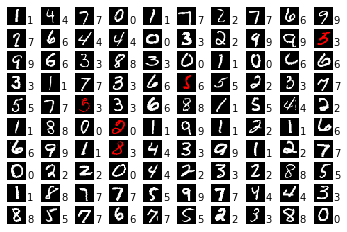

-0.9313079714775085
-0.9363089799880981
-0.9829925298690796
-0.9981382489204407
-0.9263891577720642
-0.950356662273407
-0.9639458656311035
-0.9406391382217407
-0.9670947790145874
-0.9087173342704773

Test set: Average loss: -0.9595, Accuracy: 9610/10000 (96.10%)



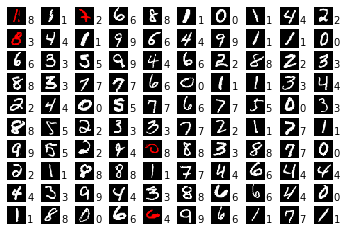

-0.9691503643989563
-0.9789814352989197
-0.922336995601654
-0.9889589548110962
-0.9823204278945923
-0.9588983058929443
-0.9843583703041077
-0.9559944272041321
-0.9723218679428101
-0.9838246703147888

Test set: Average loss: -0.9687, Accuracy: 9697/10000 (96.97%)



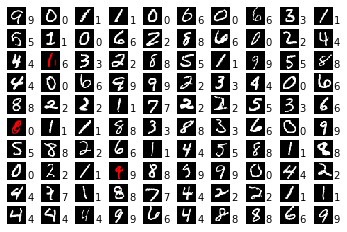

-0.9996722340583801
-0.9461116790771484
-0.9690198302268982
-0.9823964834213257
-0.9922916889190674
-0.9473356008529663
-0.9991625547409058
-0.9604047536849976
-0.9887821674346924
-0.9411590695381165

Test set: Average loss: -0.9735, Accuracy: 9741/10000 (97.41%)



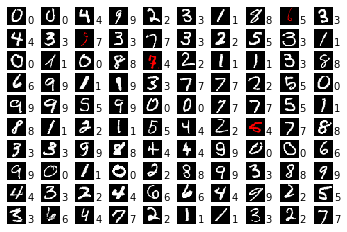

-0.9677268862724304
-0.9336941242218018
-0.9837183952331543
-0.9687331318855286
-0.999747097492218
-0.9624640941619873
-0.9876455664634705
-0.9999517798423767
-0.9993417859077454
-0.9998923540115356

Test set: Average loss: -0.9760, Accuracy: 9772/10000 (97.72%)



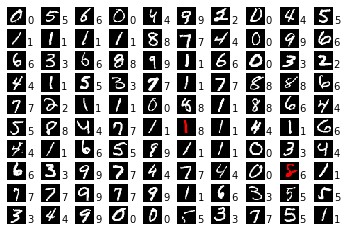

-0.9917289018630981
-0.984228253364563
-0.9678817987442017
-0.9999803304672241
-0.9996908903121948
-0.9792149066925049
-0.9525036215782166
-0.999464750289917
-0.9837403297424316
-0.998073399066925

Test set: Average loss: -0.9776, Accuracy: 9788/10000 (97.88%)



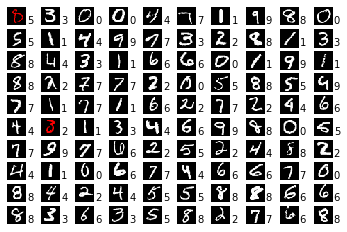

-0.9853125214576721
-0.940821647644043
-0.950800359249115
-0.973136842250824
-0.9898039698600769
-0.9980300664901733
-0.9687387943267822
-0.9768511056900024
-0.9994293451309204
-0.9950029850006104

Test set: Average loss: -0.9775, Accuracy: 9786/10000 (97.86%)



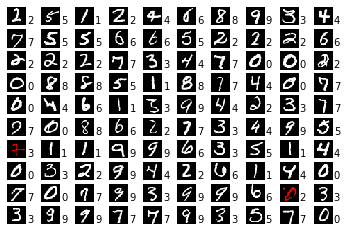

-0.9854155778884888
-0.9869261384010315
-0.994148313999176
-0.9920833110809326
-0.9962897896766663
-0.9998172521591187
-0.9843716621398926
-0.9843767881393433
-0.984020471572876
-0.984143853187561

Test set: Average loss: -0.9786, Accuracy: 9794/10000 (97.94%)



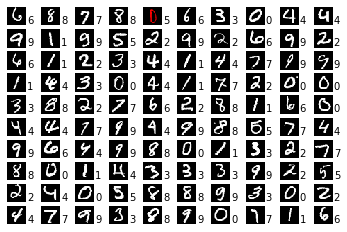

-0.9998605251312256
-0.9990429282188416
-0.969646155834198
-0.9999922513961792
-0.9944309592247009
-0.9984288215637207
-0.9665559530258179
-0.9860326051712036
-0.9855304956436157
-0.9960342645645142

Test set: Average loss: -0.9773, Accuracy: 9780/10000 (97.80%)



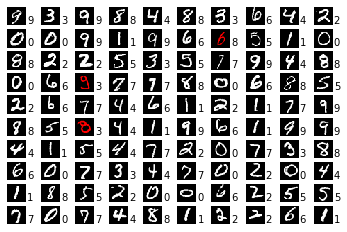

-0.9722026586532593
-0.9531148076057434
-0.9720154404640198
-0.9837968349456787
-0.9993143081665039
-0.9843686819076538
-0.9999900460243225
-0.9965425729751587
-0.9990480542182922
-0.9998599886894226

Test set: Average loss: -0.9787, Accuracy: 9798/10000 (97.98%)



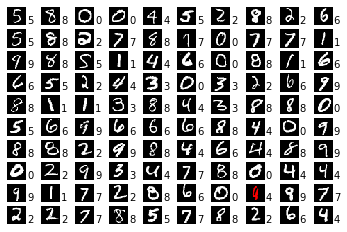

-0.1008310616016388
-0.7370142936706543
-0.6208894848823547
-0.8203700184822083
-0.6863062977790833
-0.7811170816421509
-0.7898191809654236
-0.7332870364189148
-0.7975305318832397
-0.9842677712440491

Test set: Average loss: -0.9400, Accuracy: 9424/10000 (94.24%)



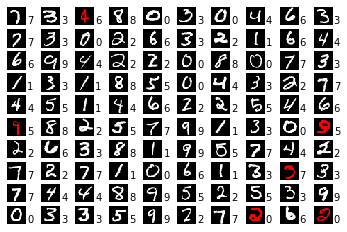

-0.9244933724403381
-0.9172857999801636
-0.9658393263816833
-0.9286022186279297
-0.9377655386924744
-0.9654296636581421
-0.9826222062110901
-0.9408544301986694
-0.9675493836402893
-0.9233568906784058

Test set: Average loss: -0.9717, Accuracy: 9727/10000 (97.27%)



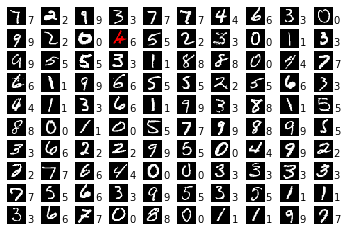

-0.9480829834938049
-0.9557424783706665
-0.9816166758537292
-0.9684280157089233
-0.9713994264602661
-0.9563887119293213
-0.9845762252807617
-0.9579862952232361
-0.9781501889228821
-0.9900140762329102

Test set: Average loss: -0.9765, Accuracy: 9782/10000 (97.82%)



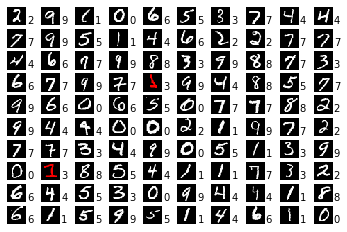

-0.9822129607200623
-0.9939947128295898
-0.9843154549598694
-0.9693519473075867
-0.9687438607215881
-0.958878755569458
-0.9957199096679688
-0.9989360570907593
-0.9999033808708191
-0.9991093873977661

Test set: Average loss: -0.9817, Accuracy: 9825/10000 (98.25%)



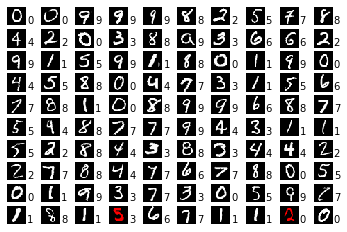

-0.9999922513961792
-0.9825466871261597
-0.9994229674339294
-0.981766402721405
-0.9843529462814331
-0.9959146976470947
-0.9999551773071289
-0.9685940146446228
-0.9832025170326233
-0.9996898174285889

Test set: Average loss: -0.9835, Accuracy: 9840/10000 (98.40%)



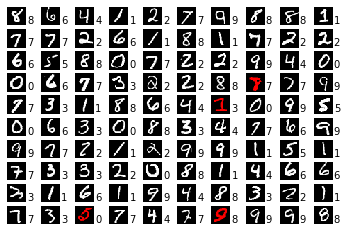

-0.9836128950119019
-0.9731565117835999
-0.9997066259384155
-0.9682852029800415
-0.9770605564117432
-0.9987833499908447
-0.9842565655708313
-0.9980913400650024
-0.999889075756073
-0.9999349117279053

Test set: Average loss: -0.9849, Accuracy: 9855/10000 (98.55%)



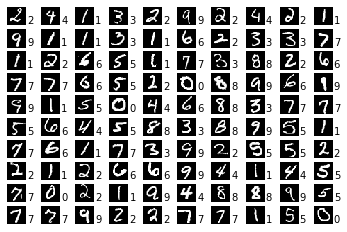

-0.9995644092559814
-0.9843859076499939
-0.999152660369873
-0.9998806118965149
-0.9840307235717773
-0.9996703863143921
-0.9830912351608276
-0.9999990463256836
-0.9997528195381165
-0.9999578595161438

Test set: Average loss: -0.9849, Accuracy: 9848/10000 (98.48%)



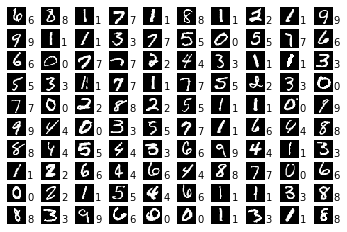

-0.998518168926239
-0.9990954399108887
-0.9837847352027893
-0.999977707862854
-0.9989437460899353
-0.9843040704727173
-0.9999986886978149
-0.9967107772827148
-0.9843185544013977
-0.9994149208068848

Test set: Average loss: -0.9850, Accuracy: 9850/10000 (98.50%)



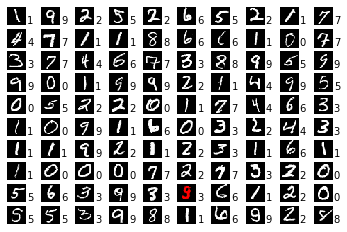

-0.9854340553283691
-0.9832848310470581
-0.9999862313270569
-0.9843606352806091
-0.9843558073043823
-0.953130304813385
-0.999982476234436
-0.996687650680542
-0.9843671321868896
-0.9842603206634521

Test set: Average loss: -0.9853, Accuracy: 9857/10000 (98.57%)



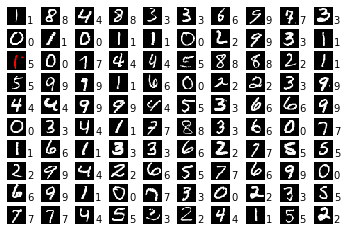

-0.9843363761901855
-0.9992702603340149
-0.999769926071167
-0.9999955892562866
-0.9998641014099121
-0.9987083077430725
-0.9843162298202515
-0.9531015753746033
-0.9847915172576904
-0.9843652844429016

Test set: Average loss: -0.9852, Accuracy: 9850/10000 (98.50%)



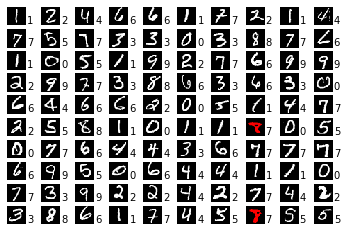

-0.08906279504299164
-0.9372814893722534
-0.9935144782066345
-0.9710125923156738
-0.9820979237556458
-0.9918178915977478
-0.9608154296875
-0.9324922561645508
-0.994127631187439
-0.9803128242492676

Test set: Average loss: -0.9710, Accuracy: 9771/10000 (97.71%)



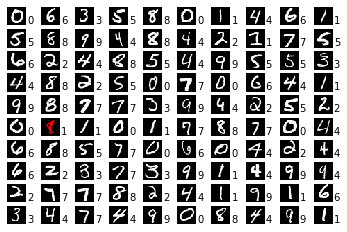

-0.9889980554580688
-0.9996973872184753
-0.9857642650604248
-0.9959831833839417
-0.9963425397872925
-0.9984303116798401
-0.9862720370292664
-0.9843094348907471
-0.9711307883262634
-0.9954939484596252

Test set: Average loss: -0.9858, Accuracy: 9881/10000 (98.81%)



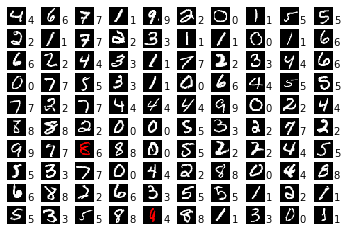

-0.9994783997535706
-0.989345908164978
-0.962853729724884
-0.9994214177131653
-0.9988229870796204
-0.9994666576385498
-0.9927687644958496
-0.9995176792144775
-0.9983084201812744
-0.9992923140525818

Test set: Average loss: -0.9884, Accuracy: 9903/10000 (99.03%)



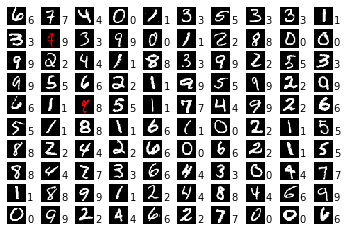

-0.9995908737182617
-0.9932635426521301
-0.9999344944953918
-0.999859631061554
-0.9909096956253052
-0.9968488812446594
-0.9987413883209229
-0.983147382736206
-0.9998682141304016
-0.9986352324485779

Test set: Average loss: -0.9898, Accuracy: 9918/10000 (99.18%)



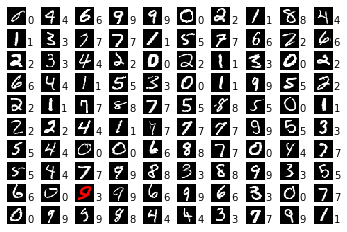

-0.998731791973114
-0.984105110168457
-0.9912296533584595
-0.9825677275657654
-0.9840297102928162
-0.9961768388748169
-0.9993023872375488
-0.9935519099235535
-0.9985215067863464
-0.9819962978363037

Test set: Average loss: -0.9907, Accuracy: 9923/10000 (99.23%)



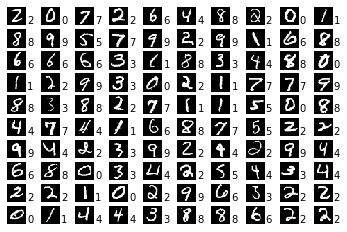

-0.9843249917030334
-0.9995070099830627
-0.998357355594635
-0.9996688961982727
-0.999913215637207
-0.9998788237571716
-0.9999305605888367
-0.9998200535774231
-0.9998165369033813
-0.9980002641677856

Test set: Average loss: -0.9901, Accuracy: 9912/10000 (99.12%)



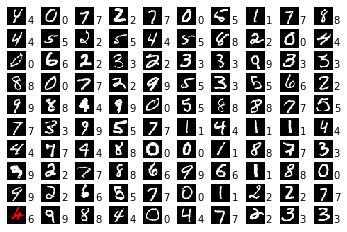

-0.9998807907104492
-0.999559223651886
-0.9998055696487427
-0.9994480609893799
-0.999517560005188
-0.9992760419845581
-0.9994926452636719
-0.997765839099884
-0.9999533295631409
-0.9986485838890076

Test set: Average loss: -0.9908, Accuracy: 9926/10000 (99.26%)



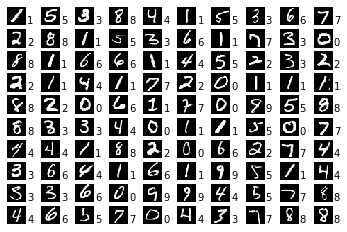

-0.9991099238395691
-0.9989134073257446
-0.9987496733665466
-0.9686484932899475
-0.9994215965270996
-0.9998483657836914
-0.999828577041626
-0.9998365640640259
-0.9998842477798462
-0.9719348549842834

Test set: Average loss: -0.9908, Accuracy: 9926/10000 (99.26%)



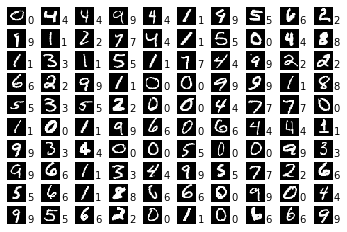

-0.9999467134475708
-0.9999091625213623
-0.9985737800598145
-0.9997752904891968
-0.9999284148216248
-0.9996694922447205
-0.9836575984954834
-0.9999760389328003
-0.9843157529830933
-0.9998910427093506

Test set: Average loss: -0.9906, Accuracy: 9923/10000 (99.23%)



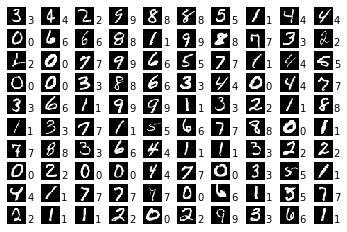

-0.9996092319488525
-0.9842886328697205
-0.9996986985206604
-0.9999611973762512
-0.983497142791748
-0.9998292922973633
-0.9995864629745483
-0.9997149705886841
-0.9999046325683594
-0.9990288019180298

Test set: Average loss: -0.9906, Accuracy: 9923/10000 (99.23%)



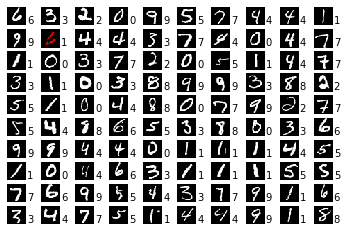

-0.09551284462213516
-0.9464868307113647
-0.9811030626296997
-0.9899806976318359
-0.9416984915733337
-0.9854660034179688
-0.9954747557640076
-0.9917280077934265
-0.9561753273010254
-0.9560069441795349

Test set: Average loss: -0.9825, Accuracy: 9852/10000 (98.52%)



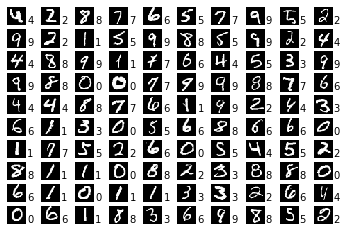

-0.972693145275116
-0.9632987976074219
-0.9995150566101074
-0.9996422529220581
-0.971952497959137
-0.9999149441719055
-0.9842222332954407
-0.9828413724899292
-0.9965878129005432
-0.9997075796127319

Test set: Average loss: -0.9872, Accuracy: 9896/10000 (98.96%)



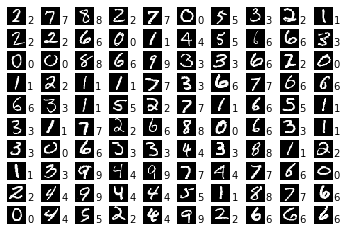

-0.9998082518577576
-0.9850941300392151
-0.9825759530067444
-0.9922358989715576
-0.9998546242713928
-0.9836649894714355
-0.9940851330757141
-0.984075129032135
-0.9708335995674133
-0.9986937642097473

Test set: Average loss: -0.9895, Accuracy: 9917/10000 (99.17%)



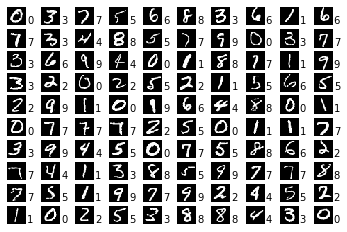

-0.9685280323028564
-0.9969146251678467
-0.9997480511665344
-0.9977368712425232
-0.9999639987945557
-0.9958831071853638
-0.9920081496238708
-0.984145998954773
-0.9837731122970581
-0.9825425744056702

Test set: Average loss: -0.9893, Accuracy: 9906/10000 (99.06%)



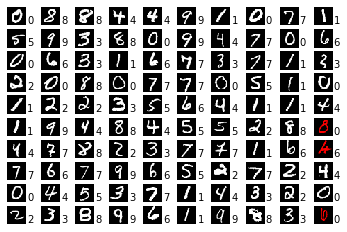

-0.999955952167511
-0.9995063543319702
-0.9841787219047546
-0.9980270266532898
-0.9994018077850342
-0.9997706413269043
-0.984359860420227
-0.9996716976165771
-0.9999189972877502
-0.992095410823822

Test set: Average loss: -0.9902, Accuracy: 9914/10000 (99.14%)



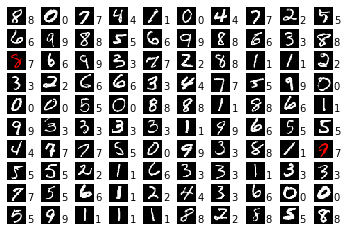

-0.9995772242546082
-0.9999022483825684
-0.9997736811637878
-0.9960436820983887
-0.9999346733093262
-0.9846986532211304
-0.9991750121116638
-0.9983367323875427
-0.9956064224243164
-0.9992971420288086

Test set: Average loss: -0.9901, Accuracy: 9916/10000 (99.16%)



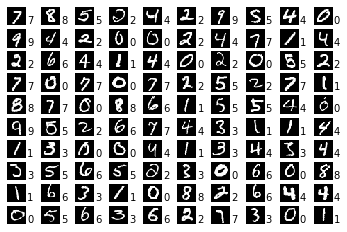

-0.9999896883964539
-0.9838051199913025
-0.999798595905304
-0.9996933937072754
-0.9827436804771423
-0.9994921088218689
-0.9996076226234436
-0.9998347163200378
-0.9841163158416748
-0.9952870011329651

Test set: Average loss: -0.9905, Accuracy: 9917/10000 (99.17%)



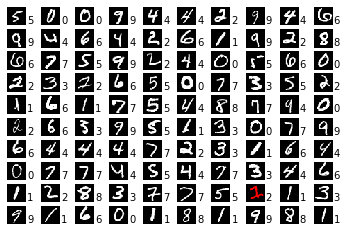

-0.9901402592658997
-0.9995351433753967
-0.9995430707931519
-0.9999101758003235
-0.999620795249939
-0.9999218583106995
-0.9999459981918335
-0.9995925426483154
-0.9992322325706482
-0.9997432231903076

Test set: Average loss: -0.9905, Accuracy: 9916/10000 (99.16%)



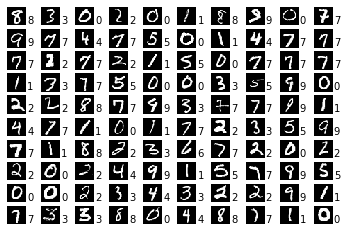

-0.982450008392334
-0.9991978406906128
-0.9859228730201721
-0.9996668696403503
-0.9999678730964661
-0.9992119669914246
-0.9984584450721741
-0.9988342523574829
-0.9999282956123352
-0.9992620944976807

Test set: Average loss: -0.9902, Accuracy: 9910/10000 (99.10%)



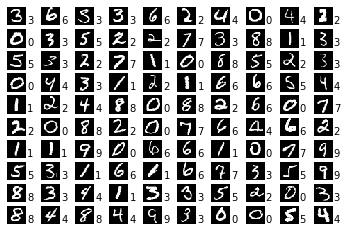

-0.9999260306358337
-0.9971720576286316
-0.9998813271522522
-0.9996231198310852
-0.999744176864624
-0.9999553561210632
-0.9999279379844666
-0.9999535083770752
-0.9843325614929199
-0.9989455938339233

Test set: Average loss: -0.9905, Accuracy: 9916/10000 (99.16%)



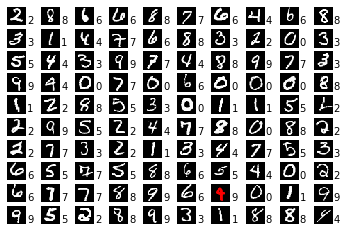

In [112]:
# hyper parameters
batch_size = 64
test_batch_size = 1000
epochs = 10
lr = 1.0
gamma = 0.7
log_interval = 100

# use GPU if available
use_cuda = torch.cuda.is_available()
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

# initialize data loaders
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])), batch_size=batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, 
    transform=transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize((0.1307,), (0.3081,))
    ])),
    batch_size=test_batch_size, shuffle=True, **kwargs)

models = [FCNet1(), FCNet2(), FCNet3(), ConvNet1(),ConvNet2(), ConvNet3()]
names = ["fcn1", "fcn2", "fcn3", "conv1", "conv2", "conv3"]

for i, (model, name) in enumerate(zip(models[:], names[:])):
    if use_cuda:
        model = model.cuda()

    # initialize optimizer and scheduler
    optimizer = optim.Adadelta(model.parameters(), lr=lr)
    scheduler = StepLR(optimizer, step_size=1, gamma=gamma)
    for epoch in range(1, epochs + 1):
        # train one epoch
        train(model, use_cuda, train_loader, optimizer, epoch, log_interval)

        # run on test dataset
        validate(model, use_cuda, test_loader)
        scheduler.step()

        torch.save(model.state_dict(), "models/mnist/checkpoint_" + name + ".pt")
        models[i] = None  # save memory